On floydhub use dataset https://www.floydhub.com/asheeshjanda/datasets/planet_amazon we have to copy the data into our persistent data store using `cp -a /floyd/input/planet_amazon /floyd/home/data`

## Multi-label prediction with Planet Amazon dataset

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# !pip install fastai --upgrade

In [3]:
from fastai.vision import *

In [4]:
from fastai.utils.collect_env import show_install
show_install()



```text
=== Software === 
python        : 3.6.5
fastai        : 1.0.42
fastprogress  : 0.1.18
torch         : 1.0.0
nvidia driver : 396.54
torch cuda    : 9.0.176 / is available
torch cudnn   : 7401 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11441MB | Tesla K80

=== Environment === 
platform      : Linux-4.4.0-1049-aws-x86_64-with-debian-stretch-sid
distro        : #58-Ubuntu SMP Fri Jan 12 23:17:09 UTC 2018
conda env     : Unknown
python        : /usr/local/bin/python
sys.path      : /usr/local/lib/python36.zip
/usr/local/lib/python3.6
/usr/local/lib/python3.6/lib-dynload

/usr/local/lib/python3.6/site-packages
/usr/local/lib/python3.6/site-packages/xgboost-0.81-py3.6.egg
/usr/local/lib/python3.6/site-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be insta

In [5]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/floyd/home/fastai/data/planet')

In [6]:
data_dir = "/floyd/home/data/planet_amazon"
path = Path(data_dir)

In [7]:
path.ls()

[PosixPath('/floyd/home/data/planet_amazon/train-jpg'),
 PosixPath('/floyd/home/data/planet_amazon/train_v2.csv'),
 PosixPath('/floyd/home/data/planet_amazon/test-jpg')]

## Multiclassification

Contrary to the pets dataset studied in last lesson, here each picture can have multiple labels. If we take a look at the csv file containing the labels (in 'train_v2.csv' here) we see that each 'image_name' is associated to several tags separated by spaces.

In [8]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageItemList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [9]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

We use parentheses around the data block pipeline below, so that we can use a multiline statement without needing to add '\\'.

In [10]:
doc(ImageItemList.from_csv)

from_csv [source] from_csv ( `path` : PathOrStr , `csv_name` : str , `header` : str = `'infer'` , `kwargs` ) → ItemList 
 
 Get the filenames in path/csv_name opened with header . 
 Show in docs

In [11]:
np.random.seed(42)
src = (ImageItemList.from_csv(path, 'train_v2.csv', folder='train-jpg', suffix='.jpg')
       .random_split_by_pct(0.2)
       .label_from_df(label_delim=' ')) # 

In [12]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` still works, and show us the different labels separated by `;`.

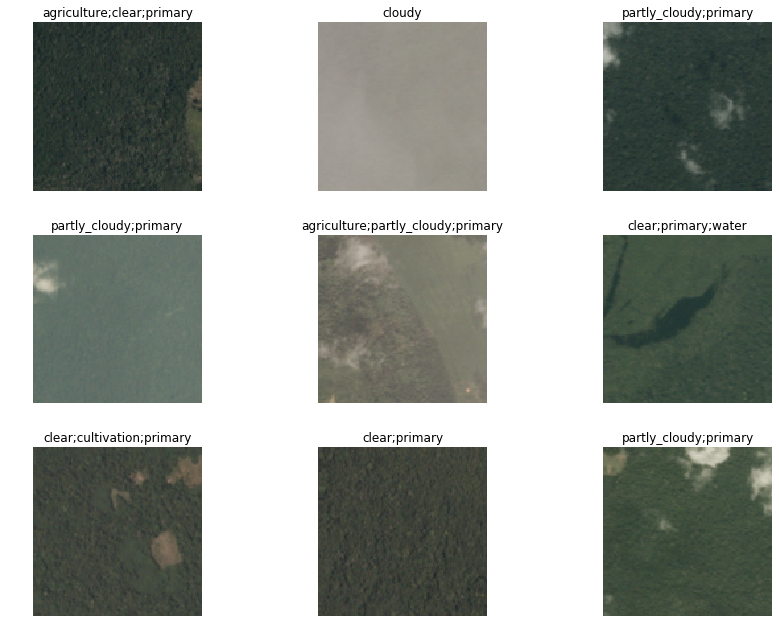

In [13]:
data.show_batch(rows=3, figsize=(12,9))

To create a `Learner` we use the same function as in lesson 1. Our base architecture is resnet34 again, but the metrics are a little bit differeent: we use `accuracy_thresh` instead of `accuracy`. In lesson 1, we determined the predicition for a given class by picking the final activation that was the biggest, but here, each activation can be 0. or 1. `accuracy_thresh` selects the ones that are above a certain threshold (0.5 by default) and compares them to the ground truth.

As for Fbeta, it's the metric that was used by Kaggle on this competition. See [here](https://en.wikipedia.org/wiki/F1_score) for more details.

In [14]:
arch = models.resnet50

In [15]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = create_cnn(data, arch, metrics=[acc_02, f_score])

We use the LR Finder to pick a good learning rate.

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


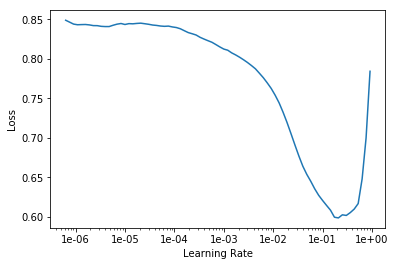

In [17]:
learn.recorder.plot()

Then we can fit the learning rate of our network.

In [18]:
lr = 0.01

In [19]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.124477,0.112722,0.945551,0.904293
2,0.110121,0.097599,0.949548,0.915886
3,0.098905,0.092658,0.959009,0.920179
4,0.094608,0.087788,0.956058,0.924816
5,0.093450,0.087083,0.957156,0.925453


In [25]:
pwd

'/floyd/home/nbs/dl1'

In [20]:
learn.save('stage-1-rn50')
learn.export('models/stage-1-rn50-export.pkl')

...And fine-tune the whole model:

In [22]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


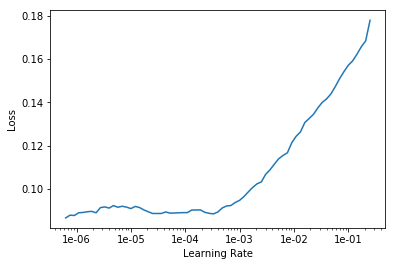

In [23]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 05:48
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.096917    0.089857    0.964909         0.923028  (01:09)
2      0.095722    0.087677    0.966341         0.924712  (01:09)
3      0.088859    0.085950    0.966813         0.926390  (01:09)
4      0.085320    0.083416    0.967663         0.927521  (01:09)
5      0.081530    0.082129    0.968121         0.928895  (01:09)



In [ ]:
learn.save('stage-2-rn50')

In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


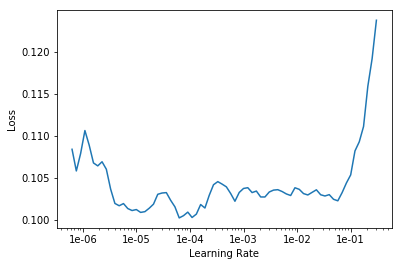

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr=1e-2/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

Total time: 14:21
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.088628    0.085883    0.966523         0.924035  (02:53)
2      0.089855    0.085019    0.967126         0.926822  (02:51)
3      0.083646    0.083374    0.967583         0.927510  (02:51)
4      0.084014    0.081384    0.968405         0.931110  (02:51)
5      0.083445    0.081085    0.968659         0.930647  (02:52)



In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 18:23
epoch  train_loss  valid_loss  accuracy_thresh  fbeta   
1      0.083591    0.082895    0.968310         0.928210  (03:41)
2      0.088286    0.083184    0.967424         0.928812  (03:40)
3      0.083495    0.083084    0.967998         0.929224  (03:40)
4      0.080143    0.081338    0.968564         0.931363  (03:40)
5      0.074927    0.080691    0.968819         0.931414  (03:41)



In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.save('stage-2-256-rn50')

You won't really know how you're going until you submit to Kaggle, since the leaderboard isn't using the same subset as we have for training. But as a guide, 50th place (out of 938 teams) on the private leaderboard was a score of `0.930`.

## fin

(We'll look at this section later - please don't ask about it just yet! :) )

In [ ]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
# ! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}

 99%|███████████████████████████████████████▋| 599M/603M [00:11<00:00, 88.6MB/s]
100%|████████████████████████████████████████| 603M/603M [00:11<00:00, 53.2MB/s]


In [ ]:
learn.load('stage-2-256-rn50')

In [ ]:
learn.data = (src.add_test_folder('test-jpg')
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))